In [240]:
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import aplpy
from astropy import units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import pandas as pd
pd.set_option('display.max_columns', 100)
import seaborn as sns
sns.set(font="times",font_scale=1.3,style="ticks")
import matplotlib as mpl
mpl.rc('text', usetex=True)
from zero_point import zpt
zpt.load_tables()
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
def Ks2R(Ks):
    # Mann+2015, < 4500K
    a = 1.9515
    b = -0.3520
    c = 0.01680
    R = a + b*Ks + c*Ks**2
    return R
def BC_K(Teff):
    # Bolometric correction for K-band
    # https://arxiv.org/pdf/astro-ph/0601049.pdf
    slope=(0.385-1.305)/2000
    BC = slope*(Teff-6000) + 1.305
    return BC

In [241]:
catalog = pd.read_csv("../files/cluster_search.csv")
from scipy import interpolate
maglim_H120s = np.load("../files/maglim_H120s.npy")
maglim_H300s = np.load("../files/maglim_H300s.npy")
maglim_J120s = np.load("../files/maglim_J120s.npy")
maglim_J300s = np.load("../files/maglim_J300s.npy")
f_H120s = interpolate.interp1d(maglim_H120s[0],maglim_H120s[1],fill_value="extrapolate")
f_H300s = interpolate.interp1d(maglim_H300s[0],maglim_H300s[1],fill_value="extrapolate")
f_J120s = interpolate.interp1d(maglim_J120s[0],maglim_J120s[1],fill_value="extrapolate")
f_J300s = interpolate.interp1d(maglim_J300s[0],maglim_J300s[1],fill_value="extrapolate")

T_sun = 5778
RJ2RSun = 0.103
RE2RSun = 6378/6.96/1e+5
RN2RSun = RE2RSun*3.8

In [297]:
def plot1(name):
    d = pd.read_csv("../match_final/"+name+".csv")
        # radius is True
    c_val1 = d[~np.isnan(d.radius_val)]
    R_val1 = np.array(c_val1.radius_val.values,dtype="float")
    K_val1 = np.array(c_val1.ks_m.values,dtype="float")
    H_val1 = np.array(c_val1.h_m.values,dtype="float")
    J_val1 = np.array(c_val1.j_m.values,dtype="float")
    BPRP_val1 = np.array(c_val1.bp_rp.values,dtype="float")
    # radius is False & Teff is True & Parallax is True
    c_val2    = d[np.isnan(d.radius_val)&(~np.isnan(d.teff_val))&(d.parallax.values>0)]
    MK_val2   = c_val2.ks_m.values - 5*np.log10(100/c_val2.parallax.values)
    L_val2    = 10**((-0.4)*(MK_val2+BC_K(c_val2.teff_val.values)-4.74)) 
    R_val2    = np.sqrt(L_val2)*(T_sun/c_val2.teff_val.values)**2
    K_val2    = np.array(c_val2.ks_m.values,dtype="float")
    H_val2    = np.array(c_val2.h_m.values,dtype="float")
    J_val2    = np.array(c_val2.j_m.values,dtype="float")
    BPRP_val2 = np.array(c_val2.bp_rp.values,dtype="float")
    # radius is False & Teff is False & Parallax is True
    c_val3    = d[np.isnan(d.radius_val)&(np.isnan(d.teff_val))&(d.parallax.values>0)]
    MK_val3   = c_val3.ks_m.values - 5*np.log10(100/c_val3.parallax.values)
    R_val3    = Ks2R(MK_val3)
    K_val3    = np.array(c_val3.ks_m.values,dtype="float")
    H_val3    = np.array(c_val3.h_m.values,dtype="float")
    J_val3    = np.array(c_val3.j_m.values,dtype="float")
    BPRP_val3 = np.array(c_val3.bp_rp.values,dtype="float")
    # Sum
    R_val    = np.hstack([R_val1,R_val2,R_val3])
    K_val    = np.hstack([K_val1,K_val2,K_val3])
    H_val    = np.hstack([H_val1,H_val2,H_val3])
    J_val    = np.hstack([J_val1,J_val2,J_val3])
    BPRP_val = np.hstack([BPRP_val1,BPRP_val2,BPRP_val3])
    #S/N factor assuming 4hr transit duration
    fac = np.sqrt(4*60/5)
    fac2 = np.sqrt(4*60/2)
    # photometric precision
    Prec_H_120s = f_H120s(H_val)
    Prec_H_300s = f_H300s(H_val)
    Prec_J_120s = f_J120s(J_val)
    Prec_J_300s = f_J300s(J_val)  
    # depth
    Radius = np.linspace(1,15,100)
    sigma=10
    Ndet_300=np.array([])
    Ndet_120=np.array([])
    for radius in Radius:
        depth = (radius*RE2RSun/R_val)**2
        SN_depth300 = depth*fac/Prec_H_300s
        SN_depth120 = depth*fac2/Prec_H_120s
        det300 = np.sum(np.where(SN_depth300>sigma,1,0))
        det120 = np.sum(np.where(SN_depth120>sigma,1,0))
        Ndet_300 = np.append(Ndet_300,det300)
        Ndet_120 = np.append(Ndet_120,det120)
    plt.plot(Radius,Ndet_300)
    #plt.title(name)
    #plt.plot(np.logspace(0,2,1000),Ndet_120)

    
def plot2(name):
    d = pd.read_csv("../match_final/"+name+".csv")
    # radius is True
    c_val1 = d[~np.isnan(d.radius_val)]
    R_val1 = np.array(c_val1.radius_val.values,dtype="float")
    K_val1 = np.array(c_val1.ks_m.values,dtype="float")
    H_val1 = np.array(c_val1.h_m.values,dtype="float")
    J_val1 = np.array(c_val1.j_m.values,dtype="float")
    BPRP_val1 = np.array(c_val1.bp_rp.values,dtype="float")
    # radius is False & Teff is True & Parallax is True
    c_val2    = d[np.isnan(d.radius_val)&(~np.isnan(d.teff_val))&(d.parallax.values>0)]
    MK_val2   = c_val2.ks_m.values - 5*np.log10(100/c_val2.parallax.values)
    L_val2    = 10**((-0.4)*(MK_val2+BC_K(c_val2.teff_val.values)-4.74)) 
    R_val2    = np.sqrt(L_val2)*(T_sun/c_val2.teff_val.values)**2
    K_val2    = np.array(c_val2.ks_m.values,dtype="float")
    H_val2    = np.array(c_val2.h_m.values,dtype="float")
    J_val2    = np.array(c_val2.j_m.values,dtype="float")
    BPRP_val2 = np.array(c_val2.bp_rp.values,dtype="float")
    # radius is False & Teff is False & Parallax is True
    c_val3    = d[np.isnan(d.radius_val)&(np.isnan(d.teff_val))&(d.parallax.values>0)]
    MK_val3   = c_val3.ks_m.values - 5*np.log10(100/c_val3.parallax.values)
    R_val3    = Ks2R(MK_val3)
    K_val3    = np.array(c_val3.ks_m.values,dtype="float")
    H_val3    = np.array(c_val3.h_m.values,dtype="float")
    J_val3    = np.array(c_val3.j_m.values,dtype="float")
    BPRP_val3 = np.array(c_val3.bp_rp.values,dtype="float")
    # Sum
    R_val    = np.hstack([R_val1,R_val2,R_val3])
    K_val    = np.hstack([K_val1,K_val2,K_val3])
    H_val    = np.hstack([H_val1,H_val2,H_val3])
    J_val    = np.hstack([J_val1,J_val2,J_val3])
    BPRP_val = np.hstack([BPRP_val1,BPRP_val2,BPRP_val3])
    # depth 
    Dep_E_val = (RE2RSun/R_val)**2
    Dep_N_val = (RN2RSun/R_val)**2
    Dep_J_val = (RJ2RSun/R_val)**2
    #S/N factor by transit duration
    fac = np.sqrt(4*60/5)
    fac2 = np.sqrt(4*60/2)
    # photometric precision
    Prec_H_120s = f_H120s(H_val)
    Prec_H_300s = f_H300s(H_val)
    Prec_J_120s = f_J120s(J_val)
    Prec_J_300s = f_J300s(J_val)
    SN_J = fac*Dep_J_val/Prec_H_300s #S/N for Jupiter
    SN_N = fac*Dep_N_val/Prec_H_300s #S/N for Jupiter
    
    
    fig,ax=plt.subplots(1,2,figsize=(12,4))
    fig.subplots_adjust(wspace=0.3)
    norm = mpl.colors.LogNorm(vmin=1,vmax=100)
    #norm = mpl.colors.LogNorm(vmin=10)
    sc=ax[0].scatter(H_val,R_val,alpha=1,c=SN_J,edgecolor="gray",cmap="seismic",norm=norm)
    cb = fig.colorbar(sc,ax=ax[0],pad=0)
    cb.set_label("S/N for transiting Jupiter")
    sc=ax[1].scatter(H_val,R_val,alpha=1,c=SN_N,edgecolor="gray",cmap="seismic",norm=norm)
    cb = fig.colorbar(sc,ax=ax[1],pad=0)
    cb.set_label("S/N for transiting Neptune")
    ax[0].fill_between((0,11),0,10,color="gray",alpha=0.8)
    ax[1].fill_between((0,11),0,10,color="gray",alpha=0.8)
    ax[0].text(10,2,"saturation limit",va="center",rotation=90,fontsize=20,c="yellow")
    ax[1].text(10,2,"saturation limit",va="center",rotation=90,fontsize=20,c="yellow")
    ax[0].set_xlim(9,16)
    ax[0].set_ylim(0,4)
    ax[1].set_xlim(9,16)
    ax[1].set_ylim(0,4)
    ax[0].set_title(name)
    ax[0].set_xlabel("$H$ (mag)")
    ax[0].set_ylabel("stellar radius ($R_\\odot$)")
    ax[1].set_xlabel("$H$ (mag)")
    ax[1].set_ylabel("stellar radius ($R_\\odot$)")
    ax[1].set_title(name)

Text(0, 0.5, 'number of stars with precision \n enough to detect transit signal')

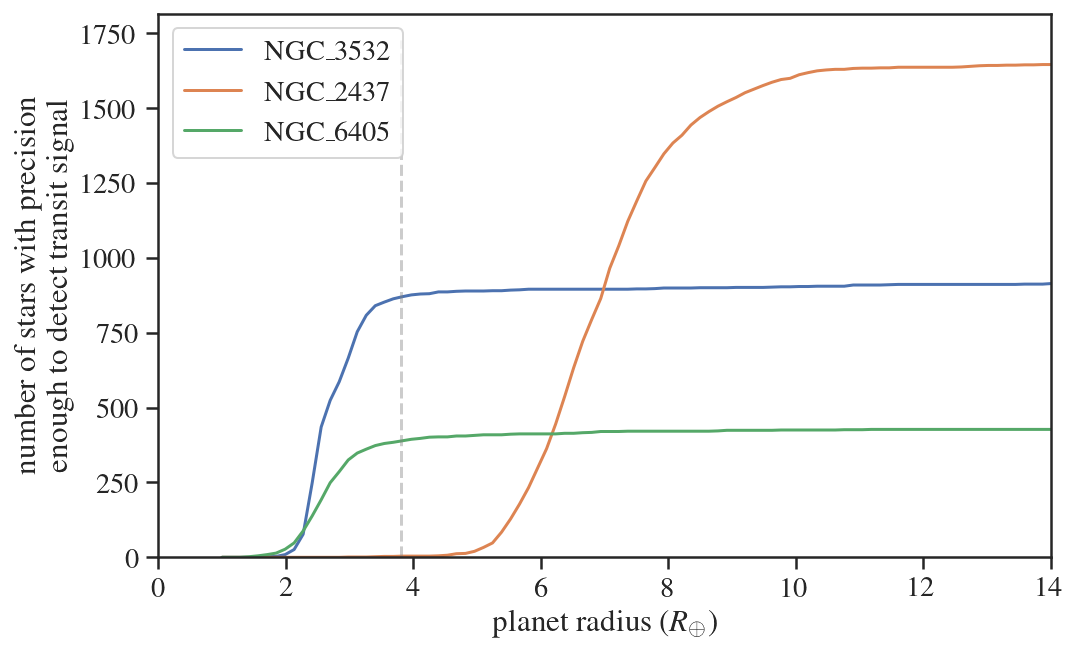

In [325]:
fig,ax=plt.subplots(figsize=(8,5))
plot1("NGC_3532")
plot1("NGC_2437")
plot1("NGC_6405")
plt.vlines(RN2RSun/RE2RSun,0,ax.get_ylim()[1],color="gray",alpha=0.4,linestyle="--")
plt.legend(["NGC_3532","NGC_2437","NGC_6405"])
plt.xlim(0,14)
plt.ylim(0,ax.get_ylim()[1])
plt.xlabel("planet radius ($R_\\oplus$)")
plt.ylabel("number of stars with precision \n enough to detect transit signal")

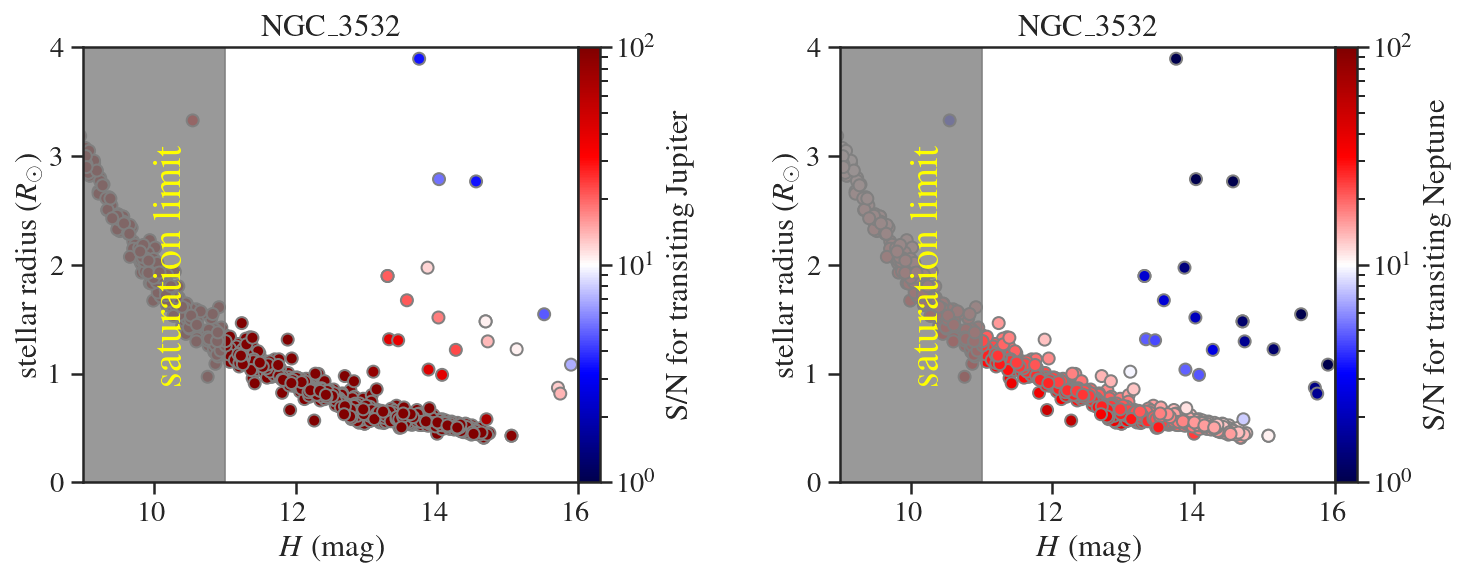

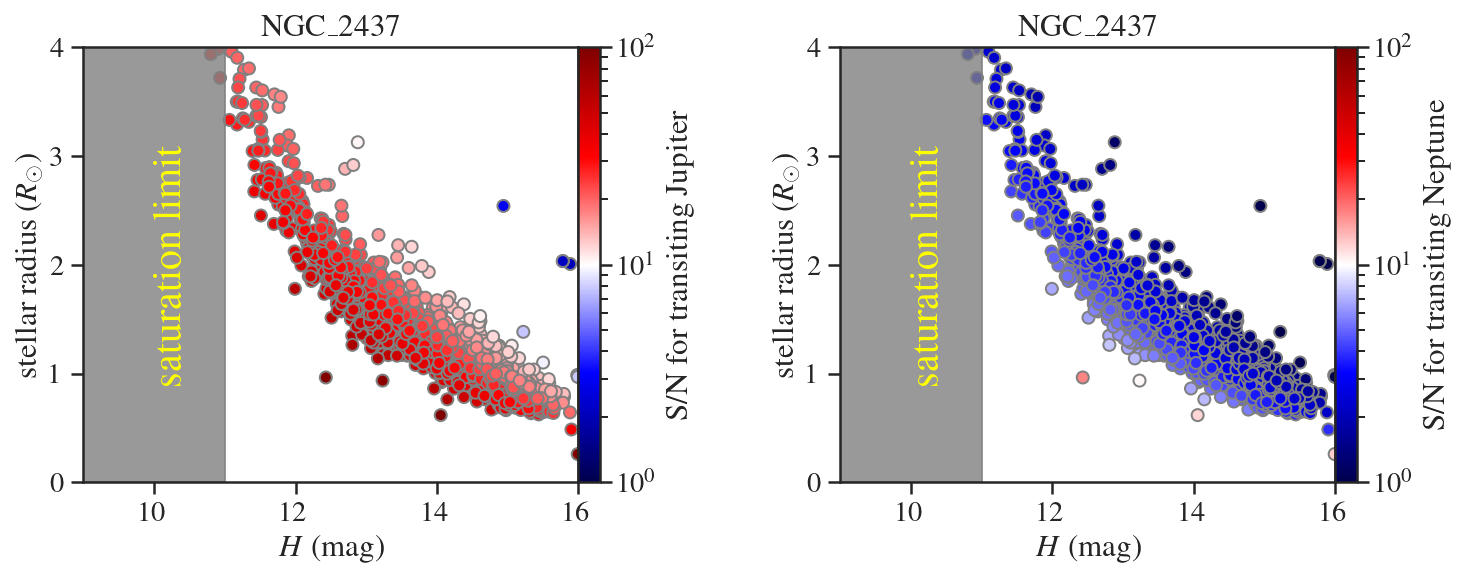

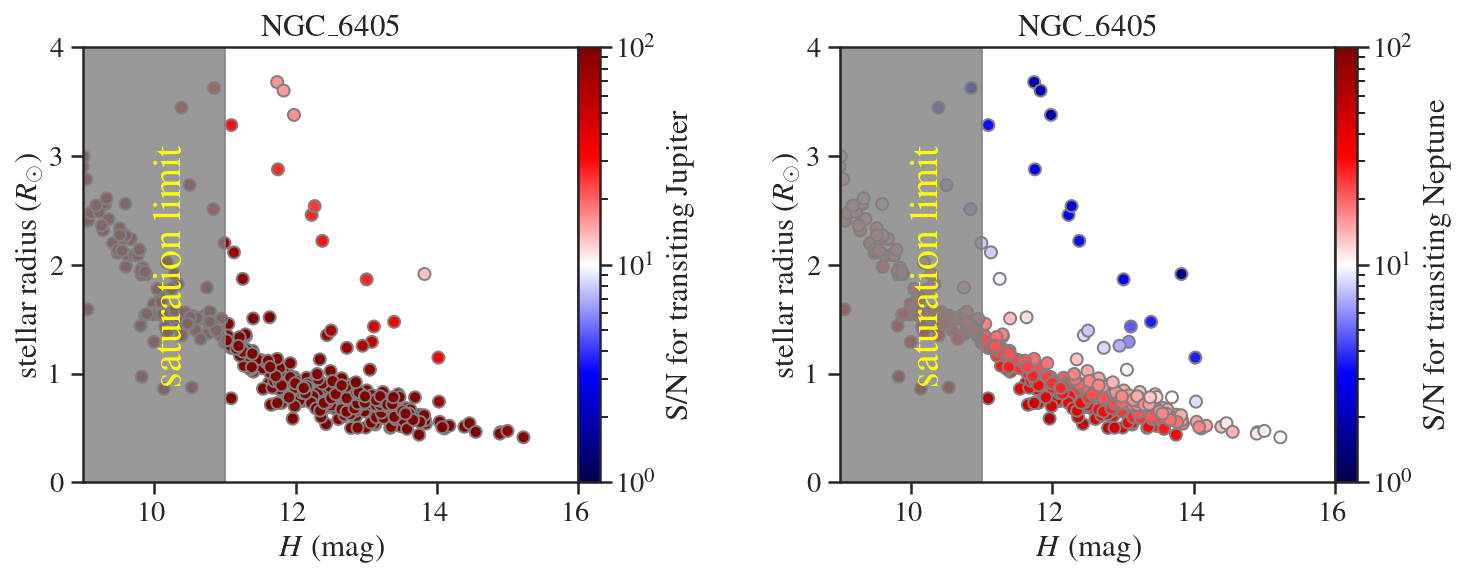

In [326]:
plot2("NGC_3532")
plot2("NGC_2437")
plot2("NGC_6405")